# Imbalanced Datasets

## Tips:
- Technique 1: 
Pick decision tree based approaches as they work better than logistic regression or SVM.
Random Forest is a good algorithm to try but beware of overfitting. 

- Technique 2: Upsample minority class

- Technique 3: Downsample majority class 

- Technique 4: A combination of Over and under sampling. 

- Technique 5: Penalize learning algorithms that increase cost of classification 
mistakes on minority classes.

- Technique 6: Generate synthetic data

- Technique 7: Add appropriate weights to your deep learning model. 

In [33]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
img = cv2.imread('images/Sandstone_Versa0180_image.tif')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

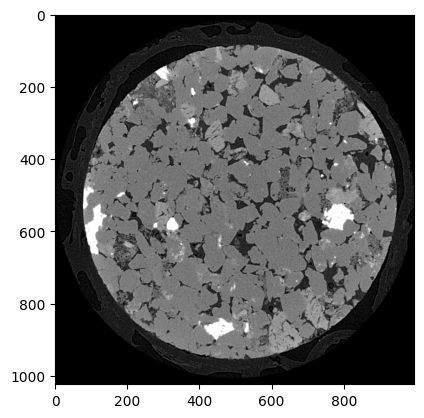

In [35]:
plt.imshow(img,cmap="grey")
plt.show()

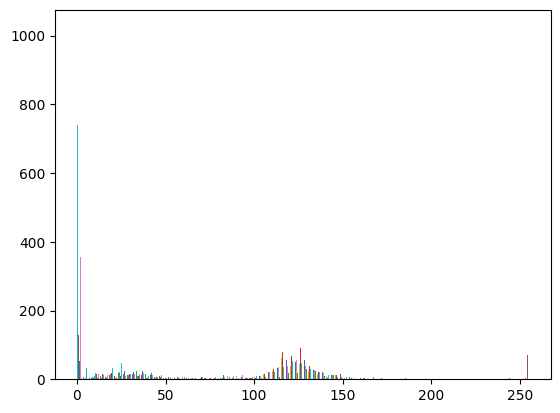

In [36]:
plt.hist(img, bins=100, range=(0,255))  #.flat returns the flattened numpy array (1D)
plt.show()

# Segmentation Task

As before, I create a pd Dataframe where in each row i keep the pixel (with different transoformations)

In [37]:
#Save original image pixels into a data frame. This is our Feature #1.
img2 = img.reshape(-1)
df = pd.DataFrame()
df['Original Image'] = img2

The transformations are from using the gabor filters

In [38]:
#Generate Gabor features
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []
for theta in range(2):   #Define number of thetas
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Now i add the label!

In [39]:
labeled_img = cv2.imread('images/Sandstone_Versa0180_mask.png')
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1
#Remember that you can load an image with partial labels 
#But, drop the rows with unlabeled data

In [40]:
print(df.Labels.unique())  #Look at the labels in our dataframe
print(df['Labels'].value_counts())

[ 33 201 231  65]
Labels
33     491532
231    439024
201     72927
65      16421
Name: count, dtype: int64


In this example image: 
- 65 - bright, 
- 201 - clay (important)
- 201 is difficult class (under represented and similar to other pixels!)
- 65 class, while under represented, it is easy to classify. 

## Defining the dataset!

In [41]:
#Let us drop background pixels.
# Normally you may want to drop unlabeled pixels with value 0
#df = df[df.Labels != 33]
#print(df['Labels'].value_counts()) 

#Define the dependent variable that needs to be predicted (labels)
Y = df["Labels"].values

#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

In [42]:
#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Technique 1: Appropriate Model Selection
- Logistic regression - Can be very slow. 
- SVM  - can also be extremely slow. 
- Random Forest - ideal for imbalanced datasets. 

In [43]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators = 10, random_state = 42)
# Train the model on training data
model_RF.fit(X_train, y_train)
#Test prediction on testing data. 
prediction_test_RF = model_RF.predict(X_test)

In [44]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_test_RF)
print(cm)

#Print individual accuracy values for each class, based on the confusion matrix
print("Pixel 33 accuracy = ", cm[0,0] / (cm[0,0]+cm[1,0]+cm[2,0]+cm[3,0]))
print("Pixel 65 accuracy = ",   cm[1,1] / (cm[0,1]+cm[1,1]+cm[2,1]+cm[3,1]))
print("Pixel 201 accuracy = ",   cm[2,2] / (cm[0,2]+cm[1,2]+cm[2,2]+cm[3,2]))
print("Pixel 231 accuracy = ",   cm[3,3] / (cm[0,3]+cm[1,3]+cm[2,3]+cm[3,3]))

[[96134     1  2100   117]
 [    0  3113     1   226]
 [ 2029     1  9128  3291]
 [   71   117  2643 85009]]
Pixel 33 accuracy =  0.9786224728709001
Pixel 65 accuracy =  0.963180693069307
Pixel 201 accuracy =  0.6580161476355249
Pixel 231 accuracy =  0.9590040950780095


In [45]:
from sklearn.metrics import roc_auc_score  #Version 0.23.1 of sklearn

#For roc_auc_score in the multiclass case, these must be probability estimates which sum to 1.
prob_y_test = model_RF.predict_proba(X_test)
print("ROC_AUC score for imbalanced data is:")
print(roc_auc_score(y_test, prob_y_test, multi_class='ovr', labels=[33, 65, 201, 231]))

ROC_AUC score for imbalanced data is:
0.9735532586462886


# Technique 2 Up-sample minority class

KEEP IN MIND:
- The Up-sampling only for the training set!

In [46]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

In [47]:
from sklearn.utils import resample
# Count the occurrences of each unique value
unique_values, counts = np.unique(X_train["Label"], return_counts=True)

# Zip the unique values and their counts together
value_count_pairs = list(zip(unique_values, counts))

print(value_count_pairs)

[(33, 393180), (65, 13081), (201, 58478), (231, 351184)]


In [48]:
#Separate majority and minority classes
X_train_important = X_train[X_train["Label"] == 201] ## The hardest class!
X_train_majority = X_train[(X_train["Label"] == 33) | (y_train == 231)]
X_train_minority = X_train[X_train["Label"] == 65] 

In [49]:
# Upsample minority class and other classes separately
# If not, random samples from combined classes will be duplicated and we run into
#same issue as before, undersampled remians undersampled.
X_train_minority_upsampled = resample(X_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=350000,    # to match average class
                                 random_state=42) # reproducible results
X_train_minority_upsampled.shape

(350000, 34)

In [50]:
X_train_important_upsampled = resample(X_train_important, 
                                 replace=True,     # sample with replacement
                                 n_samples=350000,    # to match average class
                                 random_state=42) # reproducible results
X_train_important_upsampled.shape

(350000, 34)

In [51]:
# Combine majority class with upsampled minority class
X_train_upsampled = pd.concat([X_train_majority, X_train_important_upsampled, X_train_minority_upsampled])
print(X_train_upsampled['Label'].value_counts())

Label
33     393180
231    351184
201    350000
65     350000
Name: count, dtype: int64


In [52]:
Y_train_upsampled = X_train_upsampled["Label"].values
X_train_upsampled = X_train_upsampled.drop(labels = ["Label"], axis=1) 

In [53]:
Y_test = X_test["Label"].values
X_test = X_test.drop(labels = ["Label"], axis=1)

In [54]:
#Train again with new upsamples data
model_RF_upsampled = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Train the model on training data
model_RF_upsampled.fit(X_train_upsampled, Y_train_upsampled)

RandomForestClassifier(n_estimators=10, random_state=42)

In [55]:
prediction_test_RF_upsampled = model_RF_upsampled.predict(X_test)
cm_upsampled = confusion_matrix(y_test, prediction_test_RF_upsampled)
print(cm_upsampled)

print("Pixel 33 accuracy = ", cm_upsampled[0,0] / (cm_upsampled[0,0]+cm_upsampled[1,0]+cm_upsampled[2,0]+cm_upsampled[3,0]))
print("Pixel 65 accuracy = ",  cm_upsampled[1,1] / (cm_upsampled[0,1]+cm_upsampled[1,1]+cm_upsampled[2,1]+cm_upsampled[3,1]))
print("Pixel 201 accuracy = ",  cm_upsampled[2,2] / (cm_upsampled[0,2]+cm_upsampled[1,2]+cm_upsampled[2,2]+cm_upsampled[3,2]))
print("Pixel 231 accuracy = ",  cm_upsampled[3,3] / (cm_upsampled[0,3]+cm_upsampled[1,3]+cm_upsampled[2,3]+cm_upsampled[3,3]))

prob_y_test_upsampled = model_RF.predict_proba(X_test)

[[95724     2  2540    86]
 [    0  3123     4   213]
 [ 1483     2 10172  2792]
 [   42   180  3795 83823]]
Pixel 33 accuracy =  0.9843186048185586
Pixel 65 accuracy =  0.9443604475355307
Pixel 201 accuracy =  0.6160741323965842
Pixel 231 accuracy =  0.9644361092574268


In [56]:
print("ROC_AUC score for balanced data using upsampling is:")
print(roc_auc_score(y_test, prob_y_test_upsampled, multi_class='ovr', labels=[33, 65, 201, 231]))

ROC_AUC score for balanced data using upsampling is:
0.9735532586462886


Therefore, there is an improvment!

# Technique 3
- Downsample majority class

In [57]:
df_majority_downsampled = resample(X_train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=30000,     # to match average class
                                 random_state=42) # reproducible results

#Concatenate both downsampled and upsampled to get balanced dataset
X_train_balanced = pd.concat([df_majority_downsampled, X_train_important, X_train_minority])
print(df_balanced['Label'].value_counts())

Label
201    58478
33     16005
231    13995
65     13081
Name: count, dtype: int64


In [58]:
Y_train_balanced = X_train_balanced["Label"].values
X_train_balanced= X_train_balanced.drop(labels = ["Label"], axis=1) 

In [61]:
#Train again with new upsamples data
model_RF_upsampled = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Train the model on training data
model_RF_upsampled.fit(X_train_balanced ,Y_train_balanced)
prediction_test_RF_upsampled = model_RF_upsampled.predict(X_test)
cm_upsampled = confusion_matrix(y_test, prediction_test_RF_upsampled)
print(cm_upsampled)

print("Pixel 33 accuracy = ", cm_upsampled[0,0] / (cm_upsampled[0,0]+cm_upsampled[1,0]+cm_upsampled[2,0]+cm_upsampled[3,0]))
print("Pixel 65 accuracy = ",  cm_upsampled[1,1] / (cm_upsampled[0,1]+cm_upsampled[1,1]+cm_upsampled[2,1]+cm_upsampled[3,1]))
print("Pixel 201 accuracy = ",  cm_upsampled[2,2] / (cm_upsampled[0,2]+cm_upsampled[1,2]+cm_upsampled[2,2]+cm_upsampled[3,2]))
print("Pixel 231 accuracy = ",  cm_upsampled[3,3] / (cm_upsampled[0,3]+cm_upsampled[1,3]+cm_upsampled[2,3]+cm_upsampled[3,3]))

prob_y_test_balanced = model_RF.predict_proba(X_test)

[[91489     4  6847    12]
 [    0  3270    14    56]
 [  148     4 13650   647]
 [    1  1414 22683 63742]]
Pixel 33 accuracy =  0.998374036971562
Pixel 65 accuracy =  0.69693094629156
Pixel 201 accuracy =  0.31601611334907626
Pixel 231 accuracy =  0.9889073335712181


In [62]:
print("ROC_AUC score for balanced data using upsampling is:")
print(roc_auc_score(y_test, prob_y_test_balanced, multi_class='ovr', labels=[33, 65, 201, 231]))

ROC_AUC score for balanced data using upsampling is:
0.9735532586462886


There are less performances!

# Technique 5.
- Penalize learning algorithms that increase cost of classification mistakes on minority classes. Add class_weight='balanced'.
- ALso works for others like SVM. 

In [64]:
Y = X["Label"].values
X= X.drop(labels = ["Label"], axis=1) 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [71]:
# Instantiate model with n number of decision trees
# class_weight = 'balanced'  --> classes are automatically weighted 
#inversely proportional to how frequently they appear in the data
model_penalized = RandomForestClassifier(n_estimators = 10, 
                               class_weight='balanced', # penalize
                               random_state = 42)
# Train the model on training data
model_penalized.fit(X_train, y_train)
prediction_test_RF_upsampled = model_penalized.predict(X_test)
cm = confusion_matrix(y_test, prediction_test_RF_upsampled)
print(cm)

print("Pixel 33 accuracy = ", cm[0,0] / (cm[0,0]+cm[1,0]+cm[2,0]+cm[3,0]))
print("Pixel 65 accuracy = ",  cm[1,1] / (cm[0,1]+cm[1,1]+cm[2,1]+cm[3,1]))
print("Pixel 201 accuracy = ",  cm[2,2] / (cm[0,2]+cm[1,2]+cm[2,2]+cm[3,2]))
print("Pixel 231 accuracy = ",  cm[3,3] / (cm[0,3]+cm[1,3]+cm[2,3]+cm[3,3]))

prob_y_test_penalized = model_penalized.predict_proba(X_test)

print(roc_auc_score(y_test, prob_y_test_penalized, multi_class='ovr', labels=[33, 65, 201, 231]))

[[96230     0  1992   130]
 [    0  3098     6   236]
 [ 2126     1  8940  3382]
 [   71   104  2518 85147]]
Pixel 33 accuracy =  0.9776788889227549
Pixel 65 accuracy =  0.96721823290665
Pixel 201 accuracy =  0.6643876337693222
Pixel 231 accuracy =  0.9578378986444682
0.9736795475782574


# Technique 6:
-  Generate synthetic data (SMOTE and ADASYN)
-  SMOTE: Synthetic Minority Oversampling Technique
-  ADASYN: Adaptive Synthetic
- SMOTE may not be the best choice all the time. It is one of many things

In [69]:
#Define the dependent variable that needs to be predicted (labels)
Y = df["Labels"].values

#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [75]:
! pip install imblearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 3.3 MB/s eta 0:00:0000:0100:01


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)  #Beware, this takes some time based on the dataset size
#X_adasyn, Y_adasyn = ADASYN().fit_resample(X, Y)

                                                            
(unique, counts) = np.unique(y_train, return_counts=True)
print("Original data: ", unique, counts)
(unique2, counts2) = np.unique(y_train_smote, return_counts=True)
print("After SMOTE: ", unique2, counts2)
#(unique3, counts3) = np.unique(Y_adasyn, return_counts=True)
#print("After ADASYN: ", unique3, counts3)

model_SMOTE = RandomForestClassifier(n_estimators = 10, random_state = 42)
model_SMOTE.fit(X_train_smote, y_train_smote)

prediction_test_smote = model_SMOTE.predict(X_test)



In [78]:
cm = confusion_matrix(y_test, prediction_test_smote)
print(cm)

print("Pixel 33 accuracy = ", cm[0,0] / (cm[0,0]+cm[1,0]+cm[2,0]+cm[3,0]))
print("Pixel 65 accuracy = ",  cm[1,1] / (cm[0,1]+cm[1,1]+cm[2,1]+cm[3,1]))
print("Pixel 201 accuracy = ",  cm[2,2] / (cm[0,2]+cm[1,2]+cm[2,2]+cm[3,2]))
print("Pixel 231 accuracy = ",  cm[3,3] / (cm[0,3]+cm[1,3]+cm[2,3]+cm[3,3]))

[[95725     2  2533    92]
 [    0  3181     6   153]
 [ 1499     1 10057  2892]
 [   47   300  3426 84067]]
Pixel 33 accuracy =  0.984106259830782
Pixel 65 accuracy =  0.9130309988518944
Pixel 201 accuracy =  0.6276994133067033
Pixel 231 accuracy =  0.9640268795009403


In [79]:
prob_y_test_smote = model_RF.predict_proba(X_test)
print(roc_auc_score(y_test, prob_y_test_smote, multi_class='ovr', labels=[33, 65, 201, 231]))

0.9735532586462886


Smote does not give best results here!